In [1]:
import pandas as pd

#load the data.
df = pd.read_csv("./data/train3.csv")

In [2]:
df.shape

(56000, 3)

In [3]:
df.head()

,Text,Class,ID
0,Fun little place to stop and have lunch There...,positive,1307144
1,This place was PACKED Went for late night foo...,negative,5544361
2,We board the plane 30 minutes before the actua...,positive,5956200
3,Chaotic 4 story place but fun for kids The w...,positive,718388
4,After (intentionally) capsizing a sailboat in ...,neutral,174754


In [4]:
from random import randint

#number of texts to print.
num_sample = 10
#to store random integers in range [0, len(df)].
rand = []
#generate random integers.
for _ in range(num_sample):
    value = randint(0, len(df))
    if value not in rand:
        rand.append(value)

#print out the texts at random index computed above.
for rand_index in rand:
    print(df['Text'][rand_index], end='\n\n')

This place is fantastic  many great products in multiple categories with great pricing   Staffers were very helpful  the store is very clean  neat with very tasteful displays   There are the standard adult novelty items  but so much more  including bathing suits  cover ups  dresses  sweaters  shoes and tights   I could go on  but you should see for yourself and visit this store when you are in town 

If you compare this to the oyster bar at The Palace Station to this then you would be a little disappointed  They dont give you steamed rice and they put vegetables in the pan roasts  Just different from what Im used too  Not my fav!

So i came in last night around 8:30pm or so the cashier DENNIS was great his customer service was %100 very helpful and so friendly to me and my son i highly recomed this place thank you so much for your wonderful service :) :) :) Fort Apache and Sahara Location

Got there 20 minutes to opening on a Thursday and there were already 5 people in line   Maui onio

In [5]:
#class distribution.
(df['Class'].value_counts())

positive    38348
negative    11897
neutral      5755
Name: Class, dtype: int64

In [6]:
import numpy as np 

#adding positive, neutral and negative attributes (one-hot encoding of 'Class').
df['Positive'] = np.where(df['Class'] == 'positive', 1, 0)
df['Neutral'] = np.where(df['Class'] == 'neutral', 1, 0)
df['Negative'] = np.where(df['Class'] == 'negative', 1, 0)

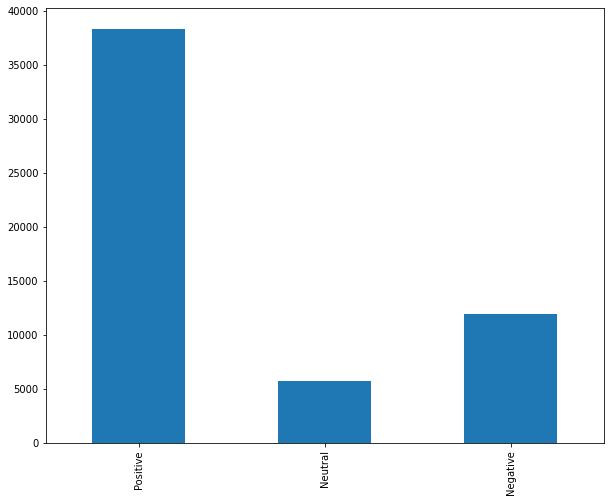

In [7]:
import matplotlib.pyplot as plt

#bar graph to show the counts of each class label.
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
df[['Positive', 'Neutral', 'Negative']].sum(axis=0).plot.bar()
plt.show()

In [8]:
import re

#a dictionary of contractions.
dict = {'isnt': 'is not',
        'arent': 'are not',
        'wasnt': 'was not',
        'werent': 'were not',
        'cant': 'can not',
        'dont': 'do not',
        'didnt': 'did not',
        'wont': 'will not',
        'wouldnt': 'would not',
        'couldnt': 'could not',
        'havent': 'have not',
        'hasnt': 'has not'}

def preprocess_text(s):
    """A function to clean the data."""
    #convert to lower case.
    s = s.casefold()
    #remove punctuations and number.
    s = re.sub(r'[^a-zA-Z]', ' ', s)
    #remove single char.
    s = re.sub(r'\s+[a-zA-Z]\s+', ' ', s)
    #remove multiple spaces.
    s = re.sub(r'\s+', ' ', s)
    #remove space at the end.
    s = s.strip()
    #remove contraction.
    for key, value in dict.items():
        s = re.sub(key, value, s)
    return s

In [9]:
#apply preprocessing on the dataset.
df['Text'] = df['Text'].apply(lambda x : preprocess_text(x))

In [10]:
df.head()

,Text,Class,ID,Positive,Neutral,Negative
0,fun little place to stop and have lunch there ...,positive,1307144,1,0,0
1,this place was packed went for late night food...,negative,5544361,0,0,1
2,we board the plane minutes before the actual f...,positive,5956200,1,0,0
3,chaotic story place but fun for kids the white...,positive,718388,1,0,0
4,after intentionally capsizing sailboat in ttl ...,neutral,174754,0,1,0


In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

test_tokenizer = Tokenizer()
test_tokenizer.fit_on_texts(list(df["Text"].values))
X_temp = test_tokenizer.texts_to_sequences(df["Text"].values)

In [12]:
max_len = 0
for _, sequence in enumerate(X_temp):
    if max_len < len(sequence):
        max_len = len(sequence)

In [13]:
max_len

198

In [14]:
max_len = 300 #since the longest sentence is 198, let's pad it to 300.

In [15]:
X = df['Text']
y = df[['Positive', 'Neutral', 'Negative']].values

In [16]:
embeddings_dict = {}
with open('glove.6B.300d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = vector

In [ ]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

#define 10-fold cross validation test.
strat_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#to store the accuracy of each fold.
cv_acc = []
index = 1
#hiden layers' size, drop out rate and batch size.
units = 500
dropout = 0.4
batch_size = 64
#perform 10-fold cv.
for train_index, test_index in strat_fold.split(X, np.argmax(y, axis=1)):
    #get the data from the indices.
    X_train, X_test = X[train_index], X[test_index]
    #Tokenize the sentences
    tokenizer = Tokenizer()
    #preparing vocabulary
    tokenizer.fit_on_texts(X_train)
    #converting text into integer sequences.
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    #padding to prepare sequences of same length.
    X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
    X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

    #+1 for padding.
    vocab_size = len(tokenizer.word_index) + 1

    #create a weight matrix for words in training docs.
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    #lstm model.
    model = Sequential()
    #embedding layer.
    model.add(Embedding(vocab_size,
                        300,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))
    #lstm layer.
    model.add(LSTM(units, return_sequences=True, dropout=dropout))
    #global maxpooling.
    model.add(GlobalMaxPooling1D())
    #dense layers.
    model.add(Dense(units, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(units, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(units, activation='relu'))
    #output layer.
    model.add(Dense(3, activation='softmax'))
    #compile model.
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

    #train the model.
    history = model.fit(X_train,
                        y[train_index],
                        batch_size=batch_size,
                        epochs=10,
                        verbose=2)

    _, acc = model.evaluate(X_test, y[test_index], batch_size=batch_size, verbose=2)
    print("Fold %d Accuracy: %f" % (index, acc))

    index += 1
    cv_acc.append(acc)

Epoch 1/10
788/788 - 45s - loss: 0.4733 - acc: 0.8208 - 45s/epoch - 57ms/step
Epoch 2/10
788/788 - 44s - loss: 0.3726 - acc: 0.8578 - 44s/epoch - 56ms/step
Epoch 3/10
788/788 - 44s - loss: 0.3427 - acc: 0.8678 - 44s/epoch - 55ms/step
Epoch 4/10
788/788 - 44s - loss: 0.3205 - acc: 0.8761 - 44s/epoch - 56ms/step
Epoch 5/10
788/788 - 44s - loss: 0.3003 - acc: 0.8843 - 44s/epoch - 56ms/step
Epoch 6/10
788/788 - 44s - loss: 0.2881 - acc: 0.8885 - 44s/epoch - 56ms/step
Epoch 7/10
788/788 - 44s - loss: 0.2661 - acc: 0.8948 - 44s/epoch - 56ms/step
Epoch 8/10
788/788 - 44s - loss: 0.2540 - acc: 0.8984 - 44s/epoch - 55ms/step
Epoch 9/10
788/788 - 44s - loss: 0.2374 - acc: 0.9046 - 44s/epoch - 55ms/step
Epoch 10/10
788/788 - 44s - loss: 0.2241 - acc: 0.9108 - 44s/epoch - 55ms/step
88/88 - 2s - loss: 0.3145 - acc: 0.8757 - 2s/epoch - 26ms/step
Fold 1 Accuracy: 0.875714
Epoch 1/10
788/788 - 45s - loss: 0.4758 - acc: 0.8207 - 45s/epoch - 57ms/step
Epoch 2/10
788/788 - 44s - loss: 0.4207 - acc: 0.838

In [ ]:
print("Mean Accuracy: %f, Standard Deviation: %f" % (np.mean(cv_acc), np.std(cv_acc)))